/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:139: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1MIAVTI2o-9166Pv2iinYXzVZNOremtEO
From (redirected): https://drive.google.com/uc?id=1MIAVTI2o-9166Pv2iinYXzVZNOremtEO&confirm=t&uuid=0cf376e2-66d2-41af-b374-7a77ccb7242e
To: /content/test.zip
100% 5.18M/5.18M [00:00<00:00, 65.9MB/s]
Loading images...
Total images: 10014
Image shape: (28, 28, 3)
Number of classes: 10
Classes: {np.str_('0'): 0, np.str_('1'): 1, np.str_('2'): 2, np.str_('3'): 3, np.str_('4'): 4, np.str_('5'): 5, np.str_('6'): 6, np.str_('7'): 7, np.str_('8'): 8, np.str_('9'): 9}

Dataset splits:
Train: 8110
Val: 902
Test: 1002

Using device: cpu

Model architecture:
CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1

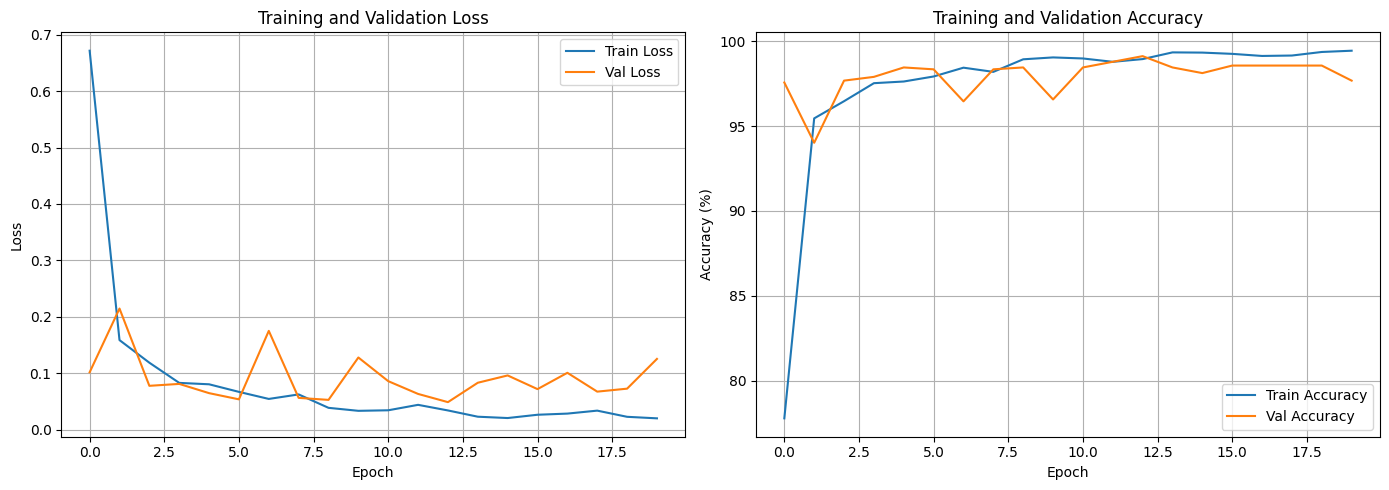


TEST RESULTS
Test Accuracy: 98.20%
Correct: 984/1002


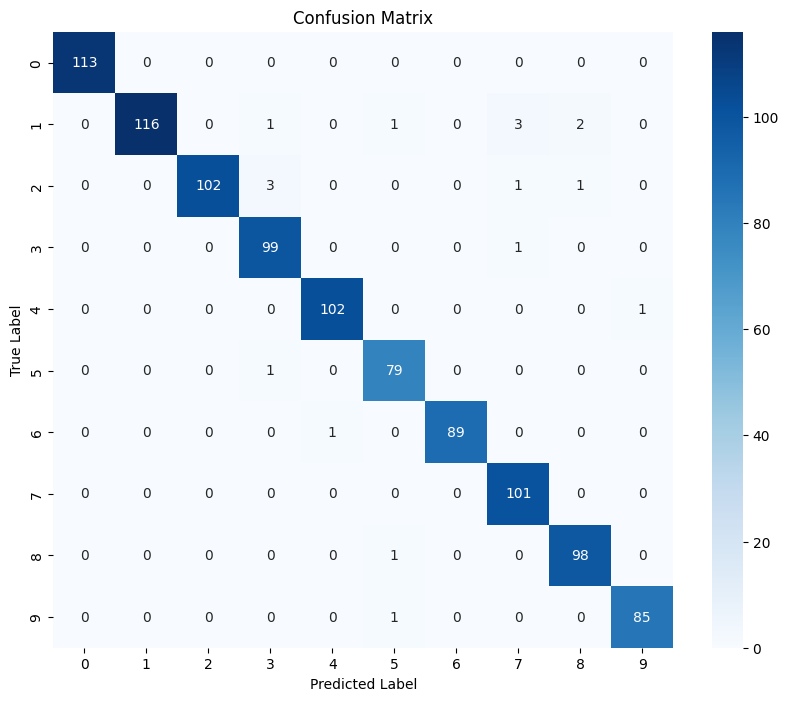


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       113
           1       1.00      0.94      0.97       123
           2       1.00      0.95      0.98       107
           3       0.95      0.99      0.97       100
           4       0.99      0.99      0.99       103
           5       0.96      0.99      0.98        80
           6       1.00      0.99      0.99        90
           7       0.95      1.00      0.98       101
           8       0.97      0.99      0.98        99
           9       0.99      0.99      0.99        86

    accuracy                           0.98      1002
   macro avg       0.98      0.98      0.98      1002
weighted avg       0.98      0.98      0.98      1002


Model saved as 'cnn_model.pth'


In [1]:
# ===========================
# 1. IMPORTS
# ===========================
import gdown
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# ===========================
# 2. DOWNLOAD AND EXTRACT DATA
# ===========================
!gdown --id 1MIAVTI2o-9166Pv2iinYXzVZNOremtEO
!unzip -q test.zip

# ===========================
# 3. DATA PREPARATION
# ===========================
IMG_WIDTH = 28
IMG_HEIGHT = 28
img_folder = "/content/test"

def create_dataset(img_folder):
    img_data_array = []
    class_name = []

    for dir1 in os.listdir(img_folder):
        dir_path = os.path.join(img_folder, dir1)
        if not os.path.isdir(dir_path):
            continue

        for file in os.listdir(dir_path):
            image_path = os.path.join(img_folder, dir1, file)
            image = cv2.imread(image_path)
            if image is None:
                continue
            image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH), interpolation=cv2.INTER_AREA)
            image = np.array(image)
            image = image.astype('float32')
            image /= 255.0
            img_data_array.append(image)
            class_name.append(dir1)

    return img_data_array, class_name

# Extract the image array and class name
print("Loading images...")
img_data, class_name = create_dataset(img_folder)

# Create target dictionary and values
target_dict = {k: v for v, k in enumerate(np.unique(class_name))}
target_val = [target_dict[class_name[i]] for i in range(len(class_name))]

# Convert to numpy arrays
img_data = np.array(img_data)
target_val = np.array(target_val)

print(f"Total images: {len(img_data)}")
print(f"Image shape: {img_data[0].shape}")
print(f"Number of classes: {len(target_dict)}")
print(f"Classes: {target_dict}")

# ===========================
# 4. TRAIN/VAL/TEST SPLIT
# ===========================
# Split: 81% train, 9% val, 10% test (matching your original split)
x, x_test, y, y_test = train_test_split(img_data, target_val, test_size=0.1, train_size=0.9, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.1, train_size=0.9, random_state=42)

print(f"\nDataset splits:")
print(f"Train: {len(x_train)}")
print(f"Val: {len(x_val)}")
print(f"Test: {len(x_test)}")

# ===========================
# 5. PYTORCH DATASET CLASS
# ===========================
class CustomDataset(Dataset):
    def __init__(self, images, labels):
        # Convert from (H, W, C) to (C, H, W) for PyTorch
        self.images = torch.FloatTensor(images).permute(0, 3, 1, 2)
        self.labels = torch.LongTensor(labels)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

# Create datasets
train_dataset = CustomDataset(x_train, y_train)
val_dataset = CustomDataset(x_val, y_val)
test_dataset = CustomDataset(x_test, y_test)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# ===========================
# 6. CNN MODEL DEFINITION
# ===========================
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        # Pooling
        self.pool = nn.MaxPool2d(2, 2)

        # Calculate the size after convolutions
        # 28x28 -> 14x14 -> 7x7 -> 3x3 (with 3 pooling layers)
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

        # Dropout
        self.dropout = nn.Dropout(0.5)

        # Activation
        self.relu = nn.ReLU()

    def forward(self, x):
        # Conv block 1
        x = self.pool(self.relu(self.bn1(self.conv1(x))))  # 28x28 -> 14x14

        # Conv block 2
        x = self.pool(self.relu(self.bn2(self.conv2(x))))  # 14x14 -> 7x7

        # Conv block 3
        x = self.pool(self.relu(self.bn3(self.conv3(x))))  # 7x7 -> 3x3

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return x

# ===========================
# 7. MODEL, LOSS, OPTIMIZER
# ===========================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")

num_classes = len(target_dict)
model = CNN(num_classes).to(device)
print(f"\nModel architecture:")
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ===========================
# 8. TRAINING FUNCTION
# ===========================
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Statistics
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_acc = 100 * train_correct / train_total
        avg_train_loss = train_loss / len(train_loader)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_acc = 100 * val_correct / val_total
        avg_val_loss = val_loss / len(val_loader)

        # Store metrics
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f'Epoch [{epoch+1}/{epochs}]')
        print(f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print('-' * 60)

    return train_losses, val_losses, train_accs, val_accs

# ===========================
# 9. TRAIN THE MODEL
# ===========================
print("\nStarting training...")
train_losses, val_losses, train_accs, val_accs = train_model(
    model, train_loader, val_loader, criterion, optimizer, epochs=20
)

# ===========================
# 10. PLOT TRAINING HISTORY
# ===========================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot loss
ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Val Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# Plot accuracy
ax2.plot(train_accs, label='Train Accuracy')
ax2.plot(val_accs, label='Val Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# ===========================
# 11. TEST THE MODEL
# ===========================
def test_model(model, test_loader):
    model.eval()
    test_correct = 0
    test_total = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_acc = 100 * test_correct / test_total
    print(f'\n{"="*60}')
    print(f'TEST RESULTS')
    print(f'{"="*60}')
    print(f'Test Accuracy: {test_acc:.2f}%')
    print(f'Correct: {test_correct}/{test_total}')
    print(f'{"="*60}')

    return all_predictions, all_labels, test_acc

predictions, true_labels, test_accuracy = test_model(model, test_loader)

# ===========================
# 12. CONFUSION MATRIX
# ===========================
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Confusion Matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_dict.keys(),
            yticklabels=target_dict.keys())
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(true_labels, predictions,
                          target_names=list(target_dict.keys())))

# ===========================
# 13. SAVE THE MODEL
# ===========================
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'target_dict': target_dict,
    'test_accuracy': test_accuracy
}, 'cnn_model.pth')

print("\nModel saved as 'cnn_model.pth'")

# ===========================
# 14. PREDICT ON NEW IMAGE
# ===========================
def predict_image(image_path, model, target_dict):
    """Predict a single image"""
    # Read and preprocess image
    image = cv2.imread(image_path)
    image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH), interpolation=cv2.INTER_AREA)
    image = image.astype('float32') / 255.0

    # Convert to tensor and add batch dimension
    image_tensor = torch.FloatTensor(image).permute(2, 0, 1).unsqueeze(0).to(device)

    # Predict
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        probabilities = torch.nn.functional.softmax(output, dim=1)
        confidence, predicted = torch.max(probabilities, 1)

    # Get class name
    inv_target_dict = {v: k for k, v in target_dict.items()}
    predicted_class = inv_target_dict[predicted.item()]

    return predicted_class, confidence.item() * 100

# Example usage (uncomment to use):
# predicted_class, confidence = predict_image('path/to/your/image.jpg', model, target_dict)
# print(f'Predicted: {predicted_class} (Confidence: {confidence:.2f}%)')

# ===========================
# 15. LOAD MODEL (for later use)
# ===========================
def load_model(model_path):
    """Load a saved model"""
    checkpoint = torch.load(model_path)

    # Recreate model
    model = CNN(len(checkpoint['target_dict'])).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])

    return model, checkpoint['target_dict']




